In [3]:
# !pip install natasha
# !pip install pyLDAvis

In [4]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from multiprocessing import Pool

from nltk.tokenize import word_tokenize
from gensim.models import *
from gensim import corpora
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [5]:
import os
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('drive/MyDrive/Colab Notebooks/NLP/Lesson4')


Mounted at /content/drive/


In [ ]:
from my_tool import txt_preprocessing

In [7]:
data = pd.read_pickle('data.pkl')

In [8]:
data.head(2)

,question,answers
0,"Прошу Вас разобраться с магазином""Связной"" По ...","Уважаемая Мария! Обращаем Ваше внимание, что м..."
1,Добрый день!\r\nПосле увольнения по собственно...,Добрый день! Роман вы вправе обратиться в Роск...


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4995 entries, 0 to 4994
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  4995 non-null   object
 1   answers   4995 non-null   object
dtypes: object(2)
memory usage: 78.2+ KB


In [10]:
data['text'] = data['question']

In [11]:
data.head(2)

,question,answers,text
0,"Прошу Вас разобраться с магазином""Связной"" По ...","Уважаемая Мария! Обращаем Ваше внимание, что м...","Прошу Вас разобраться с магазином""Связной"" По ..."
1,Добрый день!\r\nПосле увольнения по собственно...,Добрый день! Роман вы вправе обратиться в Роск...,Добрый день!\r\nПосле увольнения по собственно...


In [38]:
%%time
N = len(data)
with Pool(8) as p:
    data['prep_txt'] = tqdm(p.imap(txt_preprocessing.ru_preprocessing, data['text']), total = N)

  0%|          | 0/4995 [00:00<?, ?it/s]

CPU times: user 1.54 s, sys: 362 ms, total: 1.9 s
Wall time: 1min 19s


дополнительные стоп слова

In [34]:
stop_w = ['весь',
 'данный',
 'день',
 'добрый',
 'должный',
 'здравствуйте',
 'иметь',
 'который',
 'мера',
 'место',
 'мочь',
 'находиться',
 'наш',
 'необходимый',
 'нужный',
 'почему',
 'принять',
 'просить',
 'просто',
 'результат',
 'свой',
 'стать',
 'ул',
 'человек',
 'это',
 'являться']

In [40]:
def stop_wds(input_txt, stop_words):
    return [word for word in input_txt.split() if not word in stop_words]

In [41]:
data['prep_txt'] = data['prep_txt'].apply(lambda x: stop_wds(x, stop_w))

In [ ]:
dictionary = corpora.Dictionary(data['prep_txt'])
corpus = [dictionary.doc2bow(text) for text in data['prep_txt']]
corpora.MmCorpus.serialize('rospotreb.model', corpus) 

определим опимальное количество тем на основе максимума средней когерентности

In [ ]:
topics_list = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40, 50]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2, random_state=42)
    coherences.append(CoherenceModel(model=lda, texts=data['prep_txt'], dictionary=dictionary, coherence='c_v').get_coherence())


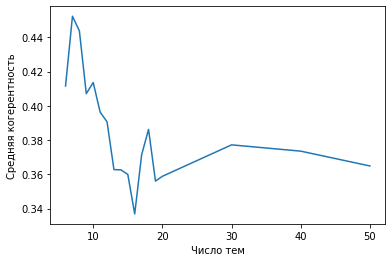

In [45]:
plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

In [46]:
print(f'Максимальная средняя когерентность: {np.array(coherences).max()},\n',
      f'при количестве тематик: {topics_list[np.array(coherences).argmax()]}')

Максимальная средняя когерентность: 0.4523497292826534,
 при количестве тематик: 7


In [ ]:
lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=7, chunksize=50, update_every=1, passes=20, random_state=42)

In [48]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda,  corpus, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.218352 -0.050741       1        1  20.770252
0     -0.009887 -0.010421       2        1  17.307821
3      0.128596  0.131461       3        1  17.028564
5      0.160064 -0.092912       4        1  14.618886
2     -0.095147  0.266307       5        1  10.871157
1     -0.262107 -0.001597       6        1  10.653748
6     -0.139871 -0.242097       7        1   8.749572, topic_info=          Term         Freq        Total Category  logprob  loglift
15     магазин  2048.000000  2048.000000  Default  30.0000  30.0000
93       товар  1675.000000  1675.000000  Default  29.0000  29.0000
538    ребенок   637.000000   637.000000  Default  28.0000  28.0000
143        дом   722.000000   722.000000  Default  27.0000  27.0000
33    продавец   767.000000   767.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
548     делать   116.103031   547.139009   Topic7  -5.2279   0.8859
1387      рука    79.536072   131.169519   Topic7  -5.6061   1.9359
536     прийти    92.534289   602.403307   Topic7  -5.4548   0.5628
518     первый    83.046249   301.349918   Topic7  -5.5630   1.1473
1577     около    76.744821   117.911576   Topic7  -5.6419   2.0067

[384 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
3298      2  0.991624        автобус
209       2  0.988639     автомобиль
1474      6  0.993748  администрация
0         1  0.112520          адрес
0         2  0.451971          адрес
...     ...       ...            ...
48        4  0.756591            чек
1496      6  0.993198          школа
2438      6  0.991612            шум
1238      4  0.990465     экспертиза
207       6  0.995034           этаж

[541 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 4, 6, 3, 2, 7])

In [49]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors


topic_weights = []
for i, row_list in enumerate(lda[corpus]):
    topic_weights.append([w for i, w in row_list])
  
arr = pd.DataFrame(topic_weights).fillna(0).values
arr = arr[np.amax(arr, axis=1) > 0.35]

topic_num = np.argmax(arr, axis=1)

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

output_notebook()
n_topics = 20
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)

plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3866 samples in 0.003s...
[t-SNE] Computed neighbors for 3866 samples in 0.146s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3866
[t-SNE] Computed conditional probabilities for sample 2000 / 3866
[t-SNE] Computed conditional probabilities for sample 3000 / 3866
[t-SNE] Computed conditional probabilities for sample 3866 / 3866
[t-SNE] Mean sigma: 0.063759


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.200424
[t-SNE] KL divergence after 1000 iterations: 1.121376


In [61]:
def get_words(model, dictionary, num_top):
    list_ = model.get_topic_terms(num_top, topn=20)
    index = [i[0] for i in list_]
    return ' '.join([dictionary.id2token[i] for  i in index])


### <b>Попытка проинтерпритировать получившиеся тематики

In [62]:
get_words(lda, dictionary, 0)

'адрес вопрос ремонт центр работа проверка ситуация связь сотрудник год жалоба просьба время сделать проблема телефон провести пожалуйста улица разобраться'

Тема1 Обращения людей связанные с работой сервисных центров

In [52]:
get_words(lda, dictionary, 1)

'дом адрес квартира проживать вода территория норма санитарный год этаж район температура управлять помещение жилой школа запах кв постоянно мусор'

Тема2 Работа ЖКХ и управаляющих компаний

In [63]:
get_words(lda, dictionary, 2)

'рф право тест закон потребитель гражданин постановление условие защита требование прививка правило продукт россия статья вакцинация ст организация основание соответствие'

Тема3 Обращения связанные с защитой прав в области вакцинации

In [54]:
get_words(lda, dictionary, 3)

'услуга договор оплата заявление пцр счет документ компания предоставить приложение банк сообщить случай карта сумма получить информация право акт подсказать'

Тема4 Вопросы в сфере исполнения договорных отношений

In [55]:
get_words(lda, dictionary, 4)

'средство возврат заказ деньга получить сайт ответ денежный вернуть оплатить доставка написать почта ситуация обращение товар сделать номер интернет отправить'

Тема5 Возврат денежных средств по заказам товаров почтой и через интернет

In [56]:
get_words(lda, dictionary, 5)

'магазин товар продавец купить покупка возврат цена вернуть приобрести деньга чек обнаружить покупатель сказать обратно гарантия пройти отказать оказаться сервисный'

Тема6 Претензии к работе магазинов, возврат, гарантийные обязательства

In [57]:
get_words(lda, dictionary, 6)

'ребенок работать час данные врач маска сказать детский посылка позвонить произойти родитель знать делать закрыть невозможный звонить ук больничный контактный'

Тема7 Область здравоохранения, в основном детская медицина